# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [1]:
import numpy as np

ADJACENCY_PATH = '../data/adjacency_matrices/'
ADJACENCY_COSINE_PATH = ADJACENCY_PATH + 'cosine'
ADJACENCY_EUC_PATH = ADJACENCY_PATH + 'eucledian'

In [2]:
adjacency =  np.load(ADJACENCY_COSINE_PATH+'.npy')
n_nodes =  adjacency.shape[0]
n_edges =  np.count_nonzero(adjacency) / 2

In [3]:
node_degrees = np.count_nonzero(adjacency, axis=1)
# Removing disconnected nodes
nodes_to_keep = np.nonzero(node_degrees)[0]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]
node_degrees = np.count_nonzero(adjacency, axis=1)
n_nodes =  adjacency.shape[0]
n_edges =  np.count_nonzero(adjacency) / 2


**Note:** The network sparsification method was changed for this milestone. We keep only links with weight higher than 0.895. Please refer to the function "sparsify_with_limit" in Milestone 1 for more details.

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [4]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [5]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    np.random.seed(seed=seed)
    adjacency = np.random.uniform(0.0, 1.0, size=(n,n))
    adjacency = (adjacency < p).astype(int)
    adjacency = np.tril(adjacency, -1) + np.tril(adjacency, -1).T
    return adjacency

Text(0.5,1.05,'Erdos-Renyi (5, 0.6)')

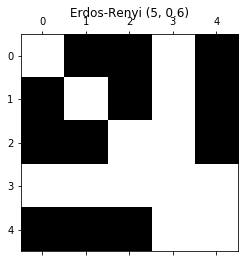

In [6]:
er = erdos_renyi(5, 0.5)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.5)')

Text(0.5,1.05,'Erdos-Renyi (10, 0.4)')

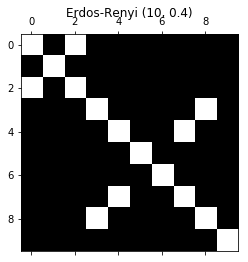

In [7]:
er = erdos_renyi(10, 0.9)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.9)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Erdos-Renyi US Senators (n_nodes, p_edge)')

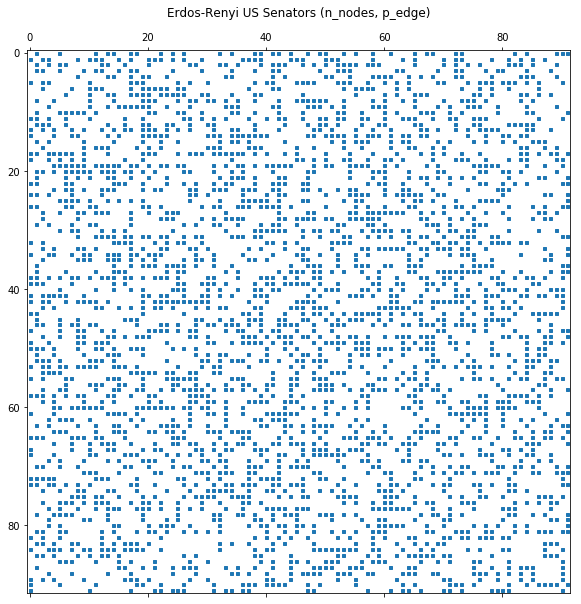

In [8]:
p_edge  =  n_edges/(n_nodes*(n_nodes-1)/2.0)
erdos_model = erdos_renyi(n_nodes,p_edge)
plt.figure(figsize=(10,10))
plt.spy(erdos_model, markersize=3)
plt.title('Erdos-Renyi US Senators (n_nodes, p_edge)')

In order to be able to compare the graph above to our network,we chose the following parameters for the Erdos-Renyi model:
- We set the  number of nodes to be equal to the number of nodes in our graph
- We set the link probability to be equal to the proportion of edges in our network compared to a fully connected one.


### Question 3

Create a function that constructs a Barabási-Albert graph.

In [9]:
def add_node_and_edges(adjacency, node_nb, m):
    """Add a node to the graph
    
    Parameters
    ----------
    adjacency
        The adjacency matrix of a graph.
    node_nb: int
        node to add
    m: int (optional)
        number of edges that connects the new node to the graph
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    node_degree = np.sum(adjacency[:node_nb],axis = 1)
    total_degrees = np.sum(node_degree)
    nodes_probabilities = node_degree / total_degrees
    new_edges = np.random.choice(node_nb, size=m, p=nodes_probabilities)
    adjacency[node_nb,new_edges] = 1
    adjacency[new_edges,node_nb] = 1

def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    assert m<=m0, "invalid Number of edges to attach from a new node to existing nodes, {} {}".format(m,m0)
    np.random.seed(seed=seed)
    
    # Create graph
    adjacency = np.zeros((n,n))
    
    # Add initial edges
    initial_component = np.zeros((m0,m0))
    for i in range(0, m0-1):
        pick = np.random.choice(list(range(i+1, m0)), size=np.random.randint(1, m0 - i))
        initial_component[i,pick] = 1
    initial_component = initial_component + initial_component.T
    
    adjacency[:m0,:m0] = initial_component
    
    # Iterative adding process
    for step in range(m0, n):
        add_node_and_edges(adjacency, step, m)
        
    
    return adjacency


Text(0.5,1.05,'Barabasi-Albert (5, 1)')

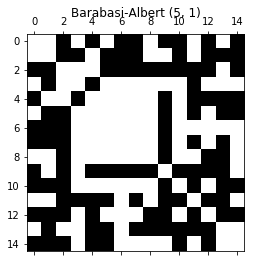

In [10]:
ba = barabasi_albert(15, 10, 10)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

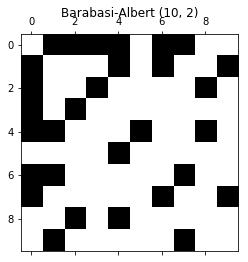

In [11]:
ba = barabasi_albert(10, 2,2)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Barabasi-Albert (34,45)')

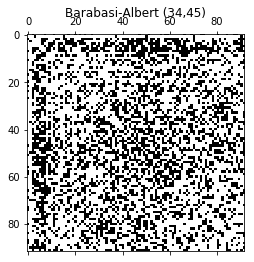

In [12]:
barabasi_model = barabasi_albert(n_nodes, int(np.mean(node_degrees)), int(np.max(node_degrees)))
plt.spy(barabasi_model)
plt.title('Barabasi-Albert ({},{})'.format(int(np.mean(node_degrees)),int(np.max(node_degrees))))

We know that m is the number of edges each node as when it is added to the graph. Hence we can choose m to be equal to the average degree, to ensure that the number of edges and the mean degree of the generated graph are close to the original one.
Furthermore , we chose to set the $m_0$ parameter to be equal to be our maximum degree since the number of nodes for the inital connected network has to be at least as big as our average degree and that our network has large clustering coefficients.

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [13]:
n_edges
erdos_renyi_edgecount = np.sum(erdos_model)/2.0
barabasi_edgecount = np.sum(barabasi_model)/2.0

print("The real network has {count} edges.".format(count=n_edges))
print("The Erdős–Rényi model has {count} edges.".format(count=erdos_renyi_edgecount))
print("The Barabási-Albert model has {count} edges.".format(count=barabasi_edgecount))

The real network has 1581.0 edges.
The Erdős–Rényi model has 1554.0 edges.
The Barabási-Albert model has 1575.0 edges.


### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [14]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    mask = np.all([p > 0.0, q > 0.0], axis=0)
    kl = np.sum(np.log(p[mask]/q[mask])*p[mask])
    
    return kl

In [15]:
# Example of the KL divergence
p_test = np.array([0.2, 0.0, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.0])
kl_divergence(p_test, q_test)

0.057536414490356194

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [16]:
def bin_range_adjust(degrees,bins):
    """Compute a binrange such that the degrees histogram contains no zero valued bin.
    
    Parameters
    ----------
    degrees: np.array
        Degrees vector
    bins: np.array
        Initial bins.
    
    Returns
    -------
    ret
        adjusted bins such that the degrees histogram contains no zero valued bin.
    """
    ret = bins.copy()
    dist = np.histogram(degrees, ret,density=False)[0]/len(degrees)
    kept_bins = (np.nonzero(dist != 0)[0])
    ret = ret[kept_bins+1] 
    ret = np.insert(ret,0,bins[0])
    ret[-1] = max(np.max(degrees)+ 1,bins[-1])

    return ret

In [17]:
binwidth = 1

# Get degrees of the two models
erdos_node_degrees = np.count_nonzero(erdos_model, axis=1)
barabasi_node_degrees = np.count_nonzero(barabasi_model, axis=1)

# Compute the adjusted bins of the erdos model
bins = np.arange(0, 99 + binwidth, binwidth)
bins = bin_range_adjust(node_degrees,bins)
bins = bin_range_adjust(erdos_node_degrees,bins)

# Compute the KL of the erdos model
real_dist = np.histogram(node_degrees, bins,density=False)[0]/len(node_degrees)
erdos_dist =  np.histogram(erdos_node_degrees, bins)[0]/len(node_degrees)
print("KL divergence between real network and Erdos model is {divergence}".format(divergence = kl_divergence(real_dist, erdos_dist)))

# Compute the adjusted bins of the barabasi model
bins = np.arange(0, 99 + binwidth, binwidth)
bins = bin_range_adjust(node_degrees,bins)
bins = bin_range_adjust(barabasi_node_degrees,bins)

# Compute the KL of the barabasi model
real_dist = np.histogram(node_degrees, bins,density=False)[0]/len(node_degrees)
barabasi_dist = np.histogram(barabasi_node_degrees, bins)[0]/len(node_degrees)
print("KL divergence between real network and Barabasi model is {divergence}".format(divergence = kl_divergence(real_dist, barabasi_dist)))

assert np.isclose(np.sum(real_dist), 1)
assert np.isclose(np.sum(erdos_dist), 1)
assert np.isclose(np.sum(barabasi_dist), 1)

KL divergence between real network and Erdos model is 0.7996776223373706
KL divergence between real network and Barabasi model is 0.6462695124897051


### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

Text(0.5,1,'Degree distribution of nodes in the Barabàsi-Albert model')

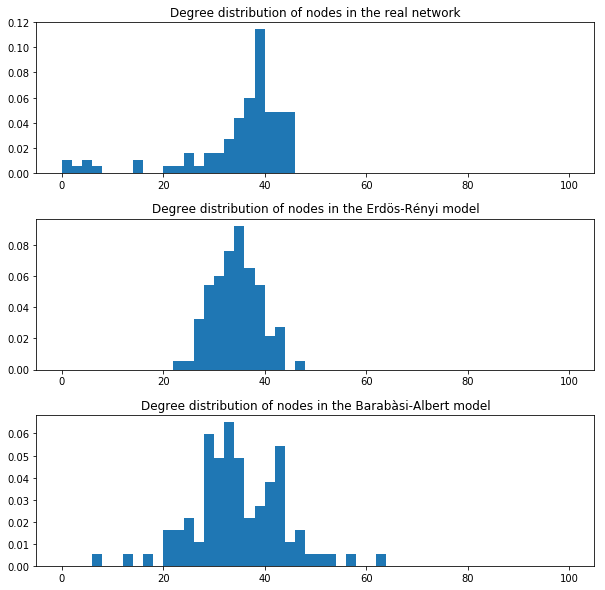

In [18]:
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(3, 1)
f.set_figheight(10)
f.set_figwidth(10)
f.subplots_adjust(hspace=0.3)
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)
axarr[0].hist(node_degrees, bins=binrange,density=True)
axarr[0].set_title("Degree distribution of nodes in the real network")
axarr[1].hist(erdos_node_degrees, bins=binrange,density=True)
axarr[1].set_title("Degree distribution of nodes in the Erdös-Rényi model")
axarr[2].hist(barabasi_node_degrees, bins=binrange,density=True)
axarr[2].set_title("Degree distribution of nodes in the Barabàsi-Albert model")

### Answer

The resulting histograms are not consistent with the KL-divergences computed above. We can see through the histograms above that our network and the Erdös-Rényi graph are skewed around the same range of values and that that their centers are close to each others.The only major difference between the latter distributions is observed for the left distribution tails as our distribution seems to have a heavier left tail compared to the Erdös-Rényi graph. Mainwhile, the degree distribution of the graph generated by the Barabàsi-Albert model have a heavier right tail and a center which does not match with our network degree distribution.


### Answer_2
The resulting histograms are consistent with the KL-divergences computed above. In fact we can see that the Barabàsi-Albert is less skewed than the Erdös-Rényi and seems to fit better the variance of our real network degree distribution. We can also see that  Barabàsi-Albert model captures well the behavior of our real network  distribution for low degrees. However, the Barabàsi-Albert model yield a distribution with a heavy right-tail which is not observed in our original network.Meanwhile, the Erdös-Rényi model yield a skewed degree distribution around its mean, which implies that this model doesn't yield a network with nodes having degrees as extreme as our real network

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

### Answer 

No, consider the following simple example:

Suppose you have n nodes, with n being a multiple of 3. Connect those nodes such as to form a circle. Clearly, the degree distribution is exactly 2 for each node. 
Now consider another graph made of n nodes where they are split into n/3 small disconnected "triangle" components. The degree distribution is again exactly two per node but the graph exhibits drastically different structures. Therefore, we cannot conclude that two graphs that have identical degree distributions are the same. 

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [19]:
import networkx as nx

In [20]:
G_real=nx.from_numpy_matrix(adjacency)
nx.write_gexf(G_real, "test.gexf")

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

### Answer

Let us begin by explaining why we believe both the Erdös-Rényi and Barabasi-Albert model are not adapted to our real network.

#### Erdös-Rényi
The Erdös-Rényi model typically shows low clustering coefficient with a degree distribution that converge in distribution to a Poisson distribution. This is not what we observe in our graph.

#### Barabasi-Albert
The Barabasi-Albert model tries to emulate a scale-free network. That is, a network whose degree distribution follows a power law which has a heavy right tail.However the degree distribution plotted above shows that our degree distribution does not exhibit such properties.Moreover  with a  Barabasi-Albert model, we expect to have a clustering coefficient close to ${ln(N)}^2/N = 0.21 $  and a few highly connected nodes which is not the case for our setup.   

#### Properties of our network
We identified the following key properties of our network:
1. It exhibits a small-world property. That is, its diameter seems to be proportional to the logarithm of the number of nodes. In milestone 1 we computed a diameter of 3 for ~100 nodes.
2. It has a high level of clustering. Indeed, in milestone 1 we computed a coefficient larger than 0.8
3. Even without being too aggressive during the sparsification procedure, we clearly see that the graph is made of two clusters. The cause is immediate if we look at the labels of the vectors used to compute the similarities. Indeed, the two clusters correspond respectively to democratic and republican senators.

We therefore opt for the *Watts-Strogatz* model which should typically have the small world property and a high clustering coefficient. We will also try a variant of the Watts-Strogatz where we start with two sets of nodes, corresponding to the democratic and republican clusters.

### Question 11

Explain (in short) how the chosen model works.

### Answer 
The model is characterized by three parameters: 

* N, the number of nodes in the network
* K, the average degree 
* p, a rewiring probability

It is built through the following procedure:

1. We start from a ring network where each node is connected to its K closest neighbors. K/2 at its left and K/2 at its right.
2. We iterate over each link and rewire it with probability p. If a link is rewired we chose the new neighbor uniformly at random (we do not allows for self-loops).

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In this part we are going to try three graph models:
* The original watts strogatz model
    
* A custom watts strogattz model where we create two watts strogatz graphs separately each having the parameters of a connected component in our original network and then we join them

* For the sake of comparison,we also tried to create a custom graph composed of two disjoint components where each one was generated using the Barabasi-Albert model with parameters corresponding to our original network components


In [21]:
def gen_watts_model(N, K, p):
    """
    Create an instance from the Watts–Strogatz graph model.
    
    Parameters
    ----------
    N: int
        The number of nodes
    K: int
        The mean degree
    p: float
        The rewiring probability
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    adjacency = np.zeros((N,N))
    
    # Build the circle lattice
    for i in range(0,N):
        for neighbor in range(int(-K/2), int(K/2 + 1)):
            adjacency[i, np.mod( i + neighbor, N)] = 1
            
    adjacency = adjacency - np.identity(N)

            
    # Rewire each node with probability p
    for i in range(0,N):
        for neighbor in range(1, int(K/2 + 1)):
            if np.random.choice([True, False], size=1, p=(p, 1-p)):
                candidate_neighbors = [x for x in np.where(adjacency[i] == 0)[0] if x != i ]
                new_neighbor = np.random.choice(candidate_neighbors, size=1)
                adjacency[i, np.mod( i + neighbor, N)] = 0
                adjacency[np.mod( i + neighbor, N), i] = 0
                adjacency[i, new_neighbor] = 1
                adjacency[new_neighbor, i] = 1

    assert np.sum(adjacency) == N * K  
    
    return adjacency

In [22]:
def find_best_watts_strogattz(range_it,node_degrees,real_net_mean_degree,real_net_diameter,real_net_average_clustering,verbose=False,seed=None):
    """
    Find the watts strogattz model rewiring probability maximizing the similarity between the watts strogattz generated network and 
    our original network.
    
    Parameters
    ----------
    range_it: np.array
        list of possible rewiring probability used for the grid search
        
    node_degrees: np.array
        The original network degrees
        
    real_net_mean_degree: int
        The original network mean degree
    
    real_net_diameter: int
        The original network diameter
        
    real_net_average_clustering:float
        The original average clustering coefficient 
    
    verbose(optional): boolean
        Variable enabling logging
     
    seed(optional):
        Random seed
    Returns
    -------
    best_kl
        Best KL divergence
    best_param
        best rewiring probability
    best_avg_clustering_coeff:
        best average clustering coefficient
    best_net:
        best network
    best_diameter:
        best network diameter
    """
    
    # Internal variables
    binwidth = 1
    arg_minimum = 1
    min_dist_average_clustering_coeff = 100000
    best_dist_diameter = 2000
    
    # Search for best parameters
    best_kl  = 123333
    best_net = None
    best_avg_clustering_coeff = None
    best_diameter = None
    
    for idx,i in enumerate(range_it):
        # Create network
        G = nx.connected_watts_strogatz_graph(len(node_degrees),real_net_mean_degree , i,seed=seed)
        
        if len(G.degree) == 0:
            continue
            
        # Compute the KL-divergence  for the sampled network
        bins = np.arange(0, 99 + binwidth, binwidth)
        watts_node_degrees = np.array(G.degree)[:,1]
        
        # Compute distributions
        bins = bin_range_adjust(node_degrees,bins)

        bins = bin_range_adjust(watts_node_degrees,bins)
        if len(bins) == 2:
            continue
        real_dist = np.histogram(node_degrees, bins)[0] / len(node_degrees)
        watts_dist = np.histogram(watts_node_degrees, bins)[0] / len(watts_node_degrees)
        kl_div = kl_divergence(real_dist, watts_dist)

        # Compute sampled network properties
        watts_network_diameter = nx.diameter(G)
        average_cluster_coeff = nx.average_clustering(G)
        dist = np.abs(average_cluster_coeff-real_net_average_clustering)
        dist_diameter = np.abs(watts_network_diameter - real_net_diameter)

        # Update best parameters
        if (kl_div < best_kl) and (arg_minimum <= idx) and dist_diameter < best_dist_diameter and (dist<min_dist_average_clustering_coeff):
            best_kl = kl_div
            arg_minimum = idx
            min_dist_average_clustering_coeff = dist
            best_avg_clustering_coeff = average_cluster_coeff
            best_net = G
            best_diameter = watts_network_diameter
        # Log current parameters
        if verbose:
            print()
            print('Rewiring probability:',i)
            print()
            print('Net diameter:',watts_network_diameter)
            print('Average clustering coeff:',average_cluster_coeff)
            print("KL divergence: {}".format(kl_div))
            
        best_param = range_it[arg_minimum]
    return best_kl,best_param,best_avg_clustering_coeff,best_net,best_diameter

In [23]:
# Create a range of rewiring probabilities to try
range_it = np.arange(0,1,0.05)

# Extract our graph connected components
all_components = [x for x in nx.connected_components(G_real)]
sub_graphs = [G_real.subgraph(x) for x in all_components]

# Compute the diameter for every component
real_net_diameters = np.array([nx.diameter(x) for x in sub_graphs])

# Compute the average clusterting coefficent for our network
real_net_average_clustering =  nx.average_clustering(G_real) 

real_net_mean_degree = int(node_degrees.mean())

### Original Watts-Strogattz model

In [24]:
minimum_kl,best_param,best_clustering_coeff,G_watts,best_diameter \
    = find_best_watts_strogattz(range_it,node_degrees,real_net_mean_degree,real_net_diameters.min(),real_net_average_clustering)

### Watts-strogattz model with two components

In [25]:
# Second graph with two components
all_components = [i for i in nx.connected_components(G_real)]
degrees = [np.array(x.degree)[:,1] for x in sub_graphs]
avg_degrees = [int(x.mean()) for x in degrees]
average_clustering_net_real = [nx.average_clustering(x) for x in sub_graphs]
best_nets = []
for idx,degs in enumerate(degrees):
    minimum_kl,best_param,best_clustering_coeff,best_net,best_diameter = find_best_watts_strogattz(range_it,degs,avg_degrees[idx],real_net_diameters[idx],average_clustering_net_real[idx])
    best_nets.append(best_net)

G_2_component_watts = nx.union(*(best_nets),rename=('C1','C2'))

### Two component Barabasi-Albert model

In [26]:
G_2_component_barabasi = [nx.from_numpy_matrix(barabasi_albert(x.number_of_nodes(),int(np.array(x.degree())[:,1].mean()),m0=np.array(x.degree())[:,1].max())) for x in sub_graphs]
G_2_component_barabasi = nx.union(*G_2_component_barabasi,rename=['C1','C2'])

### Question 13

Check the properties you expected to be similar, and compare to your network.

### Degrees Distribution histograms

Text(0.5,1,'Degree distribution of nodes in the two component Barabàsi-Albert network')

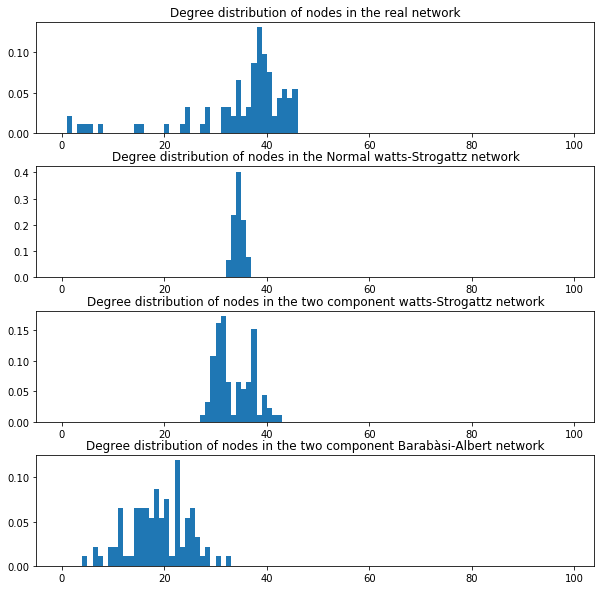

In [27]:
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(4, 1)
f.set_figheight(10)
f.set_figwidth(10)
f.subplots_adjust(hspace=0.3)
binwidth = 1
binrange = np.arange(0, 99 + binwidth, binwidth)
axarr[0].hist(node_degrees, bins=binrange,density=True)
axarr[0].set_title("Degree distribution of nodes in the real network")
axarr[1].hist(np.array(G_watts.degree)[:,1], bins=binrange,density=True)
axarr[1].set_title("Degree distribution of nodes in the Normal watts-Strogattz network")
axarr[2].hist(np.array(G_2_component_watts.degree)[:,1].astype(int), bins=binrange,density=True)
axarr[2].set_title("Degree distribution of nodes in the two component watts-Strogattz network")
axarr[3].hist(np.array(G_2_component_barabasi.degree)[:,1].astype(int), bins=binrange,density=True)
axarr[3].set_title("Degree distribution of nodes in the two component Barabàsi-Albert network")

In [28]:
def log_properties(real_net_degrees,other_dist_degrees,other_graph):
    binwidth = 2
    binrange = np.arange(0, 99 + binwidth, binwidth)
    binrange = bin_range_adjust(real_net_degrees,binrange)

    node_degrees_ = np.array(other_graph.degree)[:,1].astype(int)
    binrange = bin_range_adjust(node_degrees_,binrange)
    real_dist = np.histogram(real_net_degrees, binrange)[0] / len(real_net_degrees)
    
    other_dist = np.histogram(node_degrees_, binrange)[0] / len(node_degrees_)
    #print(binrange,np.unique(watts_node_degrees),np.unique(node_degrees))
    kl_div = kl_divergence(real_dist, other_dist)
    print('Full network KL divergence:',kl_div)
    print('Full network average clustering coefficient:',nx.average_clustering(other_graph))
    print('Full network diameters:',[nx.diameter(nx.subgraph(other_graph,x)) for x in nx.connected_components(other_graph)])
    print('Full network mean degree:',node_degrees_.mean())
    print('Full network degree std:',node_degrees_.std())
    print('Full network min and max degrees:',node_degrees_.min(),node_degrees_.max())

In [29]:
G_erdos = nx.from_numpy_matrix(erdos_model)
G_barabasi = nx.from_numpy_matrix(barabasi_model)
print('ERDOS')
log_properties(node_degrees,np.array(G_erdos.degree)[:,1],G_erdos)
print()
print('Barabasi')
log_properties(node_degrees,np.array(G_barabasi.degree)[:,1],G_barabasi)
print()
print('Normal wattz strogattz')
log_properties(node_degrees,np.array(G_watts.degree)[:,1],G_watts)
print()
print('2 components wattz strogattz')
log_properties(node_degrees,np.array(G_2_component_watts.degree)[:,1],G_2_component_watts)
print()
print('2 components barabasi')
log_properties(node_degrees,np.array(G_2_component_barabasi.degree)[:,1],G_2_component_barabasi)
print()
print('original')
log_properties(node_degrees,node_degrees,G_real)


ERDOS
Full network KL divergence: 0.574227409510373
Full network average clustering coefficient: 0.37163354531321646
Full network diameters: [2]
Full network mean degree: 33.78260869565217
Full network degree std: 4.579790404726916
Full network min and max degrees: 23 47

Barabasi
Full network KL divergence: 0.4044802496803868
Full network average clustering coefficient: 0.4203332192981475
Full network diameters: [3]
Full network mean degree: 34.23913043478261
Full network degree std: 8.983523039452733
Full network min and max degrees: 6 63

Normal wattz strogattz
Full network KL divergence: 1.1654773418941429
Full network average clustering coefficient: 0.6526466274171703
Full network diameters: [3]
Full network mean degree: 34.0
Full network degree std: 1.0108111250054497
Full network min and max degrees: 32 36

2 components wattz strogattz
Full network KL divergence: 1.1607222379525628
Full network average clustering coefficient: 0.7444070665358408
Full network diameters: [2, 2]
Ful

Are the results what you expected? Explain.

The analysis above shows that the wattz-strogatts model tends to have a average clustering coefficient and a mean degree which are close to the ones in our network. The handcrafted two component  wattz-strogatts model is even better since the latter has a higher clustering coefficient compared to the original watts-strogatts model. However these models fails to yield a degree distribution which is similar to our network, this property is best modeled by the Barabasi-Albert model